# Cooling Tower Data Analysis
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as intgr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat

### General equations
Defined as many functions as possible. i.e. Those that won't change.
* $hsat$: Enthalpy of saturated air, form for fit equation
* $Fah2Cel$: Convert Fahrenheit to Celsius
* $BTUpound2kJkg$: Convert $\frac{BTU}{lb}$ to $\frac{kJ}{kg}$

In [2]:
def hsat(T, a, b):
    return a*np.exp(b*T)
def Fah2Cel(T):
    return (T-32)*5/9
def BTUpound2kJkg(x):
    return x*2.326

### Fitting $hsat$ and plotting result

In [3]:
# Empirical/fit data
hs_T = np.array([40, 50, 60, 70, 80, 90, 100, 110, 120, 130]) # F
hs_h = np.array([15.230, 20.301, 26.46, 34.09, 43.69, 55.93, 71.73, 92.34, 119.54, 155.9]) # BTU/lb dry air

hs_T = Fah2Cel(hs_T)
hs_h = BTUpound2kJkg(hs_h)

# Fitting procedure
hsat_fit, hsat_cov = curve_fit(hsat, hs_T, hs_h, [0, 0])
fit_err = np.sqrt(np.diagonal(hsat_cov))

# Get fitted curve
hs_Tdata = np.linspace(hs_T[0], hs_T[-1], 100)
hs_hdata = hsat(hs_Tdata, *hsat_fit)
hs_h_errp = hsat(hs_Tdata, *(hsat_fit+fit_err))
hs_h_errn = hsat(hs_Tdata, *(hsat_fit-fit_err))

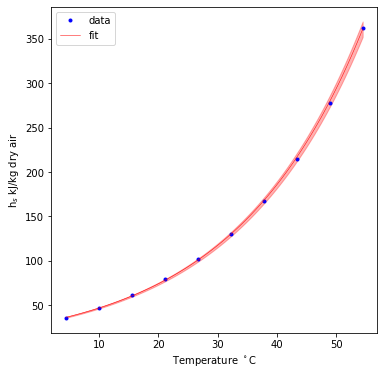

In [4]:
# Plot data and fitted curve
plt.figure(1, figsize=[6, 6])
plt.plot(hs_T, hs_h, 'b.')
plt.plot(hs_Tdata, hs_hdata, 'r-', linewidth=.5)
plt.xlabel('Temperature $^\circ$C')
plt.ylabel('h$_s$ kJ/kg dry air')
plt.legend(labels=['data', 'fit'])
plt.fill_between(hs_Tdata, hs_h_errp, hs_h_errn, color='r', alpha=0.3)
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio())
plt.savefig('Figures\hsat fit.png', dpi=300)

### Define air operating-line, Merkel equation, and power law fit
Now that $hsat$ is fitted, $enthalpy$ and $merkel$ can be defined\
It is also useful to have the power law defined for fitting

In [5]:
def enthalpy(T, Tin, Tout, LG):
    # Cp water = 4.182 kJ/kg C
    # Tout = Outlet water temperature [Celsius]
    # T = Water Temp [Celsius]
    # Tin = Wet bulb temperature in [Celsius]
    hin = hsat(Tin, *hsat_fit)
    h = hin + LG * 4.182 * (T-Tout)
    return h # [kJ/kg]
def merkel(T, Tin, Tout, LG):
    h = enthalpy(T, Tin, Tout, LG)
    hs = hsat(T, *hsat_fit)
    return 4.182/(hs-h)

## Data preprocessing

### Units
|  | Set Point Temp | Gas Flow | Liquid Flow | Outlet Water | Inlet Water | Outlet Air - Dry Bulb | Outlet Air - Wet Bulb | Inlet Air - Wet Bulb | Inlet Air - Dry Bulb |
|--------|----------------|----------|-------------|--------------|-------------|-----------------------|-----------------------|----------------------|----------------------|
| Raw | $^\circ$ C | m/s | gal/min | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |
| Desired | $^\circ$ C | kg/s | kg/s | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |

Most units can be readily converted to the desired output, with the exception of gas flow. Converting gas flow in m/s to kg/s requires the find the density of the inlet air, which is humid.

Perry's Handbook: Find saturation vapor pressure $p_{wb}$ at wet-bulb temperature $T_{wb}$ from Eq. (12-4). Find actual vapor
pressure $p$ at dry-bulb temperature $T$ from psychrometer equation (12-11). Find humid air density $\rho_g$ by
conversion from $p$ and $T$ (Table 12-2). All units in SI.

**12-4:** $\ln p_{wb} = −6096.9385T_{wb}^{−1} + 21.2409642 − 2.711193\times10^{−2}T_{wb} + 1.673952\times10^{−5}T_{wb}^2 + 2.433502 \ln T_{wb}$

where $T_{wb}$ is in Kelvin, $p_{wb}$ is in pascals.

**12-11:** $p = p_{wb} − AP(T − T_{wb})$

where $A$ is the psychrometric coefficient and $P$ is atmosphere pressure in Pa.

**12-11a:** $A = 6.5\times10^{−4}(1 + 0.000944T_{wb})$

Eq. 12-11a is valid for $T_{wb}$ up to 30 $^\circ$C.

**Table 12-2**: $\rho_g = \frac{P-0.378p}{287.1T}$

where $\rho_g$ is the humid air density (kg/m^3).

For Day 1 of this lab, Feb. 12, 2020, atmospheric pressure $P$ was 30.12 "Hg.

In [6]:
def get_rho(T, T_wb, day):
    # T = Inlet Air - Dry Bulb [Kelvin]
    # T_wb = Inlet Air - Wet Bulb [Kelvin]
    # P = 30.12 "Hg on Day 1 = 101998.03 Pa
    T = T+273.15 # convert Celsius to Kelvin
    T_wb = T_wb+273.15 # convert...
    if day == 1:
        P = 101998.03
    else:
        P = 101862.57
    p_wb = np.exp(-6096.9385*T_wb**-1 + \
                  21.2409642 - 2.711193*10**-2*T_wb + \
                  1.673952*10**-5*T_wb**2 + \
                  2.433502*np.log(T_wb))
    A = 6.5*10**-4*(1 + 0.000944*T_wb)
    p = p_wb - A*P*(T - T_wb)
    rho = (P-0.378*p)/(287.1*T)
    return rho

def get_ma(v, T, T_wb, day):
    rho = get_rho(T, T_wb, day) # kg/m^3
    V = v*np.pi/4*0.095**2 # m^3/s
    return rho*V # kg/s

### Error propagation functions

In [7]:
# dx denotes error of x

def Terr(T):
    return np.where(0.04*T > 0.5, 0.04*T, 0.5)

def Lerr(L):
    return 0.02*2

def Gerr(G):
    return np.where(0.03*G > 0.2, 0.03*G, 0.2)

def LGerr(L, G, dL, dG):
    # LG = L/G => 1/G, -L/G^2
    pL = 1/G
    pG = -1*L/G**2
    return np.sqrt(pL**2*dL**2 + pG**2*dG**2)

def Gerr2(v, T, T_wb, dv, dT, dT_wb, day):
    T = T+273.15
    T_wb = T_wb+273.15
    if day == 1:
        P = 101998.03
    else:
        P = 101862.57
    p_wb = np.exp(-6096.9385*T_wb**-1 + \
                  21.2409642 - 2.711193*10**-2*T_wb + \
                  1.673952*10**-5*T_wb**2 + \
                  2.433502*np.log(T_wb))
    A = 6.5*10**-4*(1 + 0.000944*T_wb)
    p = p_wb - A*P*(T - T_wb)
    rho = (P-0.378*p)/(287.1*T)
    V = v*np.pi/4*0.095**2 # m^3/s
    dp_wb = (6096.9385/T_wb**2 - \
                2.711193*10**-2 + \
                2*1.673952*10**-5*T_wb + \
                2.433502/T_wb)*p_wb*dT_wb
    dA = 6.5*10**-4*0.000944*dT_wb
    dp = np.sqrt(dp_wb**2 + \
                 (-P*(T - T_wb))**2*dA**2 + \
                 (A*P)**2*dT**2 + \
                 (A*P)**2*dT_wb**2
                )
    drho = np.sqrt((0.378/(287.1*T))**2*dp**2 + \
                   ((P-0.378*p)/(287.1*T**2))**2*dT**2
                  )
    dV = np.sqrt((np.pi/4*0.095**2)**2*dv**2 + \
                 (2*v*np.pi/4*0.095)**2*0.005**2
                )
    dG = np.sqrt(V**2*drho**2 + \
                 rho**2*dV**2
                )
    return dG

### Import and clean data
I had combined all the data from day 1 and added two columns, Group and Trial. These columns ended up being trivial as the liquid flow sufficed to group the data. I then aggregated by liquid flow and calculated means and standard deviations, compiling these values in a new dataframe.
### Get NTU and error
Used larger of two between instrument error and standard deviation of measurements.

In [8]:
df1 = pd.read_csv("Cooling Tower Day 1 - All.csv")
df2 = pd.read_csv("Cooling Tower Day 2 - All.csv")
df1.insert(0, 'Day', 1)
df2.insert(0, 'Day', 2)
df = df1.append(df2)

# Drop extra columns
df = df.drop(columns=['Trial'])

# Convert L and G and get L/G
df['Liquid Flow'] = df['Liquid Flow'].apply(lambda x: x*6.30902*10**-5*997)
df['Gas Flow'] = df.apply(lambda x: get_ma(x['Gas Flow'],
                                           x['Inlet Air - Dry Bulb'],
                                           x['Inlet Air - Wet Bulb'],
                                           x['Day']
                                          ),
                          axis=1
                         )
df['L/G'] = df['Liquid Flow']/df['Gas Flow']

# Calculate NTU
NTU = df.apply(lambda x: intgr.quad(merkel, x['Outlet Water'], x['Inlet Water'],
                                   args=(x['Inlet Air - Wet Bulb'], x['Outlet Water'], x['L/G'])),
             axis=1)
df['NTU'] = NTU.apply(lambda x: x[0])

# Temperature errors
rawlist = ['Outlet Water', 'Inlet Water', 'Outlet Air - Dry Bulb', 'Outlet Air - Wet Bulb', 'Inlet Air - Wet Bulb', 'Inlet Air - Dry Bulb']
errlist = ['Outlet Water - err', 'Inlet Water - err', 'Outlet Air - Dry Bulb - err', 'Outlet Air - Wet Bulb - err', 'Inlet Air - Wet Bulb - err', 'Inlet Air - Dry Bulb - err']
for raw, err in zip(rawlist, errlist):
    df[err] = Terr(df[raw])

# Flow errors
df['Liquid Flow - err'] = Lerr(df['Liquid Flow'])
df['Liquid Flow - err'] = df['Liquid Flow - err'].apply(lambda x: x*6.30902*10**-5*997)
df['Gas Flow - err'] = Gerr(df['Gas Flow'])
df['Gas Flow - err'] = df.apply(lambda x: Gerr2(x['Gas Flow'],
                                                x['Inlet Air - Dry Bulb'],
                                                x['Inlet Air - Wet Bulb'],
                                                x['Gas Flow - err'],
                                                x['Inlet Air - Dry Bulb - err'],
                                                x['Inlet Air - Wet Bulb - err'],
                                                x['Day']
                                               ),
                                axis=1
                               )
df['L/G - err'] = LGerr(df['Liquid Flow'], df['Gas Flow'], df['Liquid Flow - err'], df['Gas Flow - err'])

# Aggregate for mean and err
df_agg = df.groupby('Group').mean().reset_index()
df_NTUerr = df.groupby('Group').std().reset_index(drop=True)
df_NTUerr = df_NTUerr['NTU'].rename('NTU - err')

# Recombine
df_agg = pd.concat([df_agg, df_NTUerr], axis=1)

# Done using Day
df_agg.drop(columns='Day', inplace=True)

# df.iloc[73:]['Gas Flow'].unique()

### Calculate NTU and plot

In [9]:
g1 = df_agg[(df_agg['Set Point Temp'] == 45) & (df_agg['Gas Flow'] < 0.017)].reset_index(drop=True)
g2 = df_agg[(df_agg['Set Point Temp'] == 45) & (df_agg['Gas Flow'] > 0.017) & (df_agg['Gas Flow'] < 0.034)].reset_index(drop=True)
g3 = df_agg[(df_agg['Set Point Temp'] == 45) & (df_agg['Gas Flow'] > 0.034) & (df_agg['Gas Flow'] < 0.062)].reset_index(drop=True)
g4 = df_agg[(df_agg['Set Point Temp'] == 35) & (df_agg['Gas Flow'] < 0.018)].reset_index(drop=True)
g5 = df_agg[(df_agg['Set Point Temp'] == 35) & (df_agg['Gas Flow'] > 0.018) & (df_agg['Gas Flow'] < 0.035)].reset_index(drop=True)
g6 = df_agg[(df_agg['Set Point Temp'] == 35) & (df_agg['Gas Flow'] > 0.035) & (df_agg['Gas Flow'] < 0.068)].reset_index(drop=True)
# for g in [g1, g2, g3, g4, g5, g6]:
#     print(len(g.index))

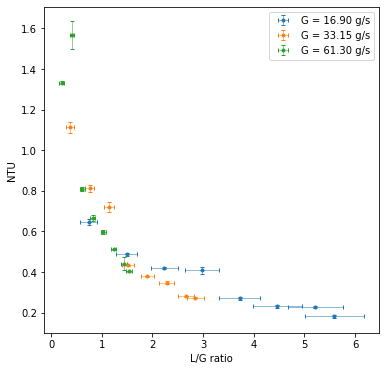

In [10]:
plt.figure(2, figsize=[6, 6])
Gs = []
for g in [g1, g2, g3]:
    plt.errorbar(g['L/G'], g['NTU'], g['NTU - err'], g['L/G - err'], fmt='.', elinewidth=.5, capsize=2)
    plt.xlabel('L/G ratio')
    plt.ylabel('NTU')
    Gs.append(g['Gas Flow'].mean()*10**3)
plt.legend(labels=[f'G = {Gs[0]:.2f} g/s', f'G = {Gs[1]:.2f} g/s', f'G = {Gs[2]:.2f} g/s'])
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.savefig('Figures\SP 45 NTU v LG.png', dpi=300)
# plt.show()

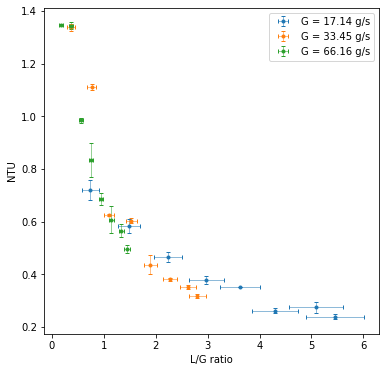

In [11]:
plt.figure(3, figsize=[6, 6])
Gs = []
for g in [g4, g5, g6]:
    plt.errorbar(g['L/G'], g['NTU'], g['NTU - err'], g['L/G - err'], fmt='.', elinewidth=.5, capsize=2)
    plt.xlabel('L/G ratio')
    plt.ylabel('NTU')
    Gs.append(g['Gas Flow'].mean()*10**3)
plt.legend(labels=[f'G = {Gs[0]:.2f} g/s', f'G = {Gs[1]:.2f} g/s', f'G = {Gs[2]:.2f} g/s'])
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.savefig('Figures\SP 35 NTU v LG.png', dpi=300)
# plt.show()

### Fitting NTU vs. L/G

In [12]:
def NTULGfit(LG, a, b):
    return a*LG**b

Best fit:
NTU = a*(L/G)^b
a = 0.71+/-0.08
b = -0.70+/-0.13
r^2 = 0.6384995547351906


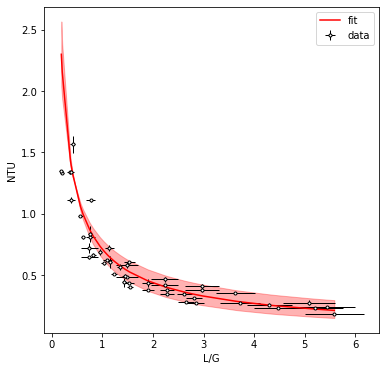

In [13]:
# Get Fit
LGweights = 1/(df_agg['L/G - err']/np.mean(df_agg['L/G - err'])+\
               (df_agg['NTU - err']/np.mean(df_agg['NTU - err'])))
LGfit, LGcov = curve_fit(NTULGfit, df_agg['L/G'], df_agg['NTU'],
                        sigma = LGweights,
                        absolute_sigma = True)
LGfit_err = np.sqrt(np.diagonal(LGcov))

# Fit Curve
LGfitx = np.sort(df['L/G'])
LGfity = NTULGfit(LGfitx, *LGfit)
LGfiterrp = NTULGfit(LGfitx, *(LGfit+LGfit_err))
LGfiterrn = NTULGfit(LGfitx, *(LGfit-LGfit_err))

# Report goodness of fit
LGfit_a = ufloat(LGfit[0], LGfit_err[0])
LGfit_b = ufloat(LGfit[1], LGfit_err[1])
ss_res = np.sum((df['NTU'] - NTULGfit(df['L/G'], *LGfit))**2)
ss_tot = np.sum((df['NTU'] - df['NTU'].mean())**2)
LGfit_r2 = 1 - (ss_res/ss_tot)
LGfit_gof = f"Best fit:\nNTU = a*(L/G)^b\na = {LGfit_a}\nb = {LGfit_b}\nr^2 = {LGfit_r2}"
print(LGfit_gof)

# Plot Fit and Data
plt.figure(3, figsize=[6, 6])
plt.errorbar(df_agg['L/G'], df_agg['NTU'], df_agg['NTU - err'], df_agg['L/G - err'], 'ok',
             markersize=3, markerfacecolor='w', label='data',
             elinewidth=1
            )
plt.plot(LGfitx, LGfity, 'r-', label='fit')
plt.xlabel('L/G')
plt.ylabel('NTU')
plt.legend()

ax = plt.gca()
# ax.set_xscale('log'); ax.set_yscale('log')
ax.fill_between(LGfitx, LGfiterrp, LGfiterrn, color='r', alpha=0.3)
# from matplotlib.ticker import ScalarFormatter
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
plt.savefig(r'Figures\NTU v LG Fit.png', dpi=300)
# plt.show()

### Plotting NTU vs. L/G with a delT color map

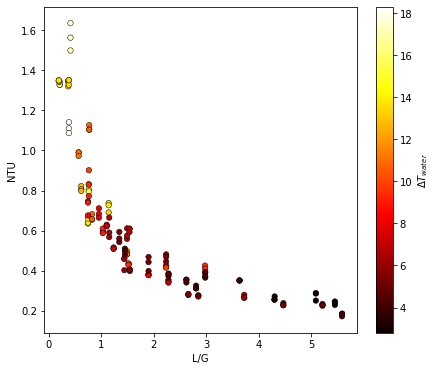

In [14]:
delT = df['Inlet Water']-df['Outlet Water']
plt.figure(4, figsize=[7, 6])
plt.scatter(df['L/G'], df['NTU'], c=delT, cmap='hot', s=30, edgecolor='k', linewidths=.5)
cbar = plt.colorbar()
cbar.set_label('$\Delta T_{water}$')
plt.xlabel('L/G')
plt.ylabel('NTU')
plt.savefig(r'Figures\NTU v LG colorbar Overlay.png', dpi=300)

In [15]:
g1a = df[(df['Set Point Temp'] == 45) & (df['Gas Flow'] < 0.017)].reset_index(drop=True)
g2a = df[(df['Set Point Temp'] == 45) & (df['Gas Flow'] > 0.017) & (df['Gas Flow'] < 0.034)].reset_index(drop=True)
g3a = df[(df['Set Point Temp'] == 45) & (df['Gas Flow'] > 0.034) & (df['Gas Flow'] < 0.062)].reset_index(drop=True)
g4a = df[(df['Set Point Temp'] == 35) & (df['Gas Flow'] < 0.018)].reset_index(drop=True)
g5a = df[(df['Set Point Temp'] == 35) & (df['Gas Flow'] > 0.018) & (df['Gas Flow'] < 0.035)].reset_index(drop=True)
g6a = df[(df['Set Point Temp'] == 35) & (df['Gas Flow'] > 0.035) & (df['Gas Flow'] < 0.068)].reset_index(drop=True)

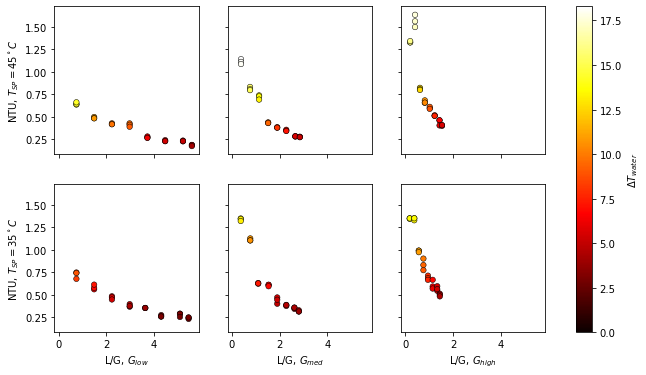

In [16]:
delT = df['Inlet Water']-df['Outlet Water']
maxdt = max(delT)
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=[11, 6])
for ax, g in zip(axs.flat, [g1a, g2a, g3a, g4a, g5a, g6a]):
    delT = g['Inlet Water']-g['Outlet Water']
    dummy = ax.scatter(g['L/G'], g['NTU'], c=delT, cmap='hot', s=30, edgecolor='k', linewidths=.5, vmin=0, vmax=maxdt)

# plt.setp(axs.flat, xlabel='L/G', ylabel='NTU')
# for ax in axs.flat:
#     ax.label_outer()
    
axs[0, 0].set(ylabel='NTU, $T_{SP} = 45^\circ C$')
axs[1, 0].set(ylabel='NTU, $T_{SP} = 35^\circ C$')
axs[1, 0].set(xlabel='L/G, $G_{low}$')
axs[1, 1].set(xlabel='L/G, $G_{med}$')
axs[1, 2].set(xlabel='L/G, $G_{high}$')
    
cbar = fig.colorbar(dummy, ax=axs.ravel().tolist())
cbar.set_label('$\Delta T_{water}$')

plt.savefig(r'Figures\NTU v LG colorbar.png', dpi=300)